## Importing the required packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,StackingClassifier,ExtraTreesClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Reading the excel into pandas dataframe
os.chdir('downloads/IU Docs/Model Engineering/Additional Documents-20231106')
df_main = pd.read_excel('use_case_1/PSP_Jan_Feb_2019.xlsx')

## Checking for datatypes and logical errors

In [3]:
# Checking the datatypes
df_main = df_main.drop('Unnamed: 0',axis=1)
df_main.dtypes

tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object

In [4]:
# Checking for data quality checks
df_main.isnull().any()

tmsp          False
country       False
amount        False
success       False
PSP           False
3D_secured    False
card          False
dtype: bool

In [5]:
# Checking for logical errors
print('Unique records for success field: ',df_main['success'].unique())
print('Unique records for 3D_secured field: ',df_main['3D_secured'].unique())
print('Is there any value in amount field less than or equal to zero: ',
      df_main[df_main['amount']<=0]['amount'].any())

Unique records for success field:  [0 1]
Unique records for 3D_secured field:  [0 1]
Is there any value in amount field less than or equal to zero:  False


## Data Distribution and Exploratory Data Analysis

In [6]:
def plot_distribution(df,axs,col,title,is_hist=False):
    if is_hist:
        axs.hist(df[col])
    else:
        class_count = {str(key):val for key,val in dict(df[col].value_counts()).items()}
        axs.bar(class_count.keys(),class_count.values())
    axs.set_title(title)

def plot_bar_distribution(df,col,title):
    class_count = {str(key):val for key,val in dict(df[col].value_counts()).items()}
    plt.bar(class_count.keys(),class_count.values())
    plt.title(title)
    plt.show()
    


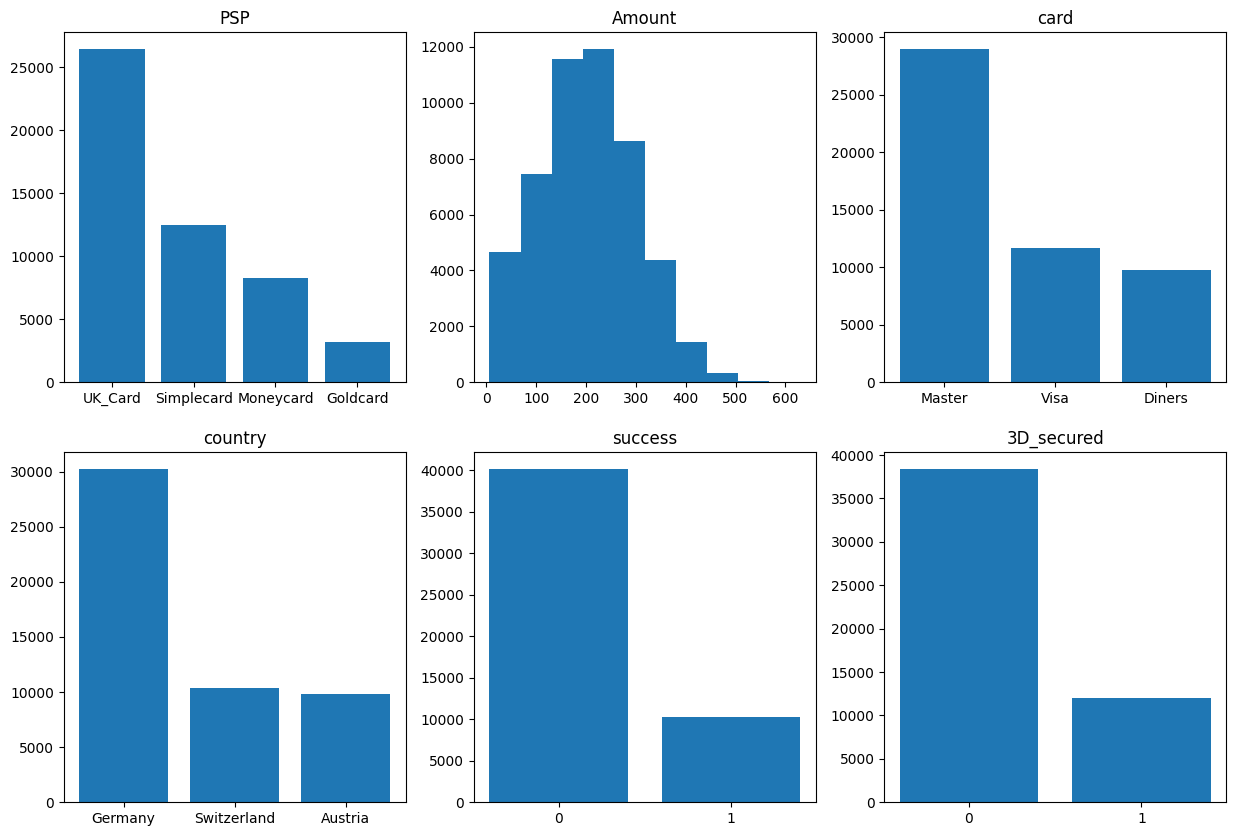

In [7]:
f, axs = plt.subplots(2, 3,figsize=(15, 10))
axs = axs.ravel()
plot_distribution(df_main,axs[0],'PSP','PSP')
plot_distribution(df_main,axs[1],'amount','Amount',is_hist=True)
plot_distribution(df_main,axs[2],'card','card')
plot_distribution(df_main,axs[3],'country','country')
plot_distribution(df_main,axs[4],'success','success')
plot_distribution(df_main,axs[5],'3D_secured','3D_secured')
plt.savefig('distribution.png',dpi=200)
plt.show()

In [8]:
# EDA on Categorical features - card, country and PSP
pd.DataFrame({'card':dict(df_main['card'].describe()),
'country':dict(df_main['country'].describe()),
'PSP':dict(df_main['PSP'].describe())}).transpose()

,count,unique,top,freq
card,50410,3,Master,29002
country,50410,3,Germany,30233
PSP,50410,4,UK_Card,26459


In [9]:
# EDA on Continuous features - amount
pd.DataFrame({'amount':dict(df_main['amount'].describe())}).transpose()

,25%,50%,75%,count,max,mean,min,std
amount,133.0,201.0,269.0,50410.0,630.0,202.395715,6.0,96.27473


In [10]:
# EDA on Timestamp features - tmsp
pd.DataFrame({'tmsp':dict(df_main['tmsp'].describe())}).transpose()

,count,first,freq,last,top,unique
tmsp,50410,2019-01-01 00:01:11,3,2019-02-28 23:48:19,2019-02-12 03:30:54,50121


In [11]:
class_count = {str(key):f'{round(val/len(df_main),2)*100}%' for key,val in dict(df_main['success'].value_counts()).items()}
print(f'Success field distribution in percentage: {class_count}')
class_count = {str(key):f'{round(val/len(df_main),2)*100}%' for key,val in dict(df_main['PSP'].value_counts()).items()}
print(f'PSP field distribution in percentage: {class_count}')
class_count = {str(key):f'{round(val/len(df_main),2)*100}%' for key,val in dict(df_main['country'].value_counts()).items()}
print(f'Country field distribution in percentage: {class_count}')
class_count = {str(key):f'{round(val/len(df_main),2)*100}%' for key,val in dict(df_main['card'].value_counts()).items()}
print(f'Card field distribution in percentage: {class_count}')

Success field distribution in percentage: {'0': '80.0%', '1': '20.0%'}
PSP field distribution in percentage: {'UK_Card': '52.0%', 'Simplecard': '25.0%', 'Moneycard': '16.0%', 'Goldcard': '6.0%'}
Country field distribution in percentage: {'Germany': '60.0%', 'Switzerland': '21.0%', 'Austria': '20.0%'}
Card field distribution in percentage: {'Master': '57.99999999999999%', 'Visa': '23.0%', 'Diners': '19.0%'}


In [12]:
print('Unique years in which the transactions are made: ',
      pd.DatetimeIndex(df_main['tmsp']).year.unique())
print('Unique months in which the transactions are made: ',
      pd.DatetimeIndex(df_main['tmsp']).month.unique())


Unique years in which the transactions are made:  Int64Index([2019], dtype='int64', name='tmsp')
Unique months in which the transactions are made:  Int64Index([1, 2], dtype='int64', name='tmsp')


## Feature Engineering

In [13]:
df = df_main.copy(deep=True)

In [14]:

df['tmsp'] = pd.to_datetime(df['tmsp'])
df['date'] = pd.DatetimeIndex(df['tmsp']).date
df.sort_values(by=['tmsp','success'])

old_country,old_amount,old_date,old_tmsp,old_success = df.iloc[0]['country'],df.iloc[0]['amount'],df.iloc[0]['date'],df.iloc[0]['tmsp'],df.iloc[0]['success']
i = 0
new_df_list = []
for row in df.to_dict('records'):
        diff_min = int((row['tmsp']-old_tmsp)/np.timedelta64(1, 'm'))
        if old_country == row['country'] and old_amount == row['amount'] and old_date == row['date'] and diff_min<=1:
            if old_success == 0:
                row['transactionID'] = i
            else:
                i+=1
                row['transactionID'] = i
            
        else:
            i+=1
            row['transactionID'] = i
            
            
        new_df_list.append(row)
        old_country,old_amount,old_date,old_tmsp,old_success= row['country'],row['amount'],row['date'],row['tmsp'],row['success']

new_df = pd.DataFrame(new_df_list)

old_ID = new_df.iloc[0]['transactionID']
new_df_list = []
attempt = 0
for row in new_df.to_dict('records'):
    if row['transactionID'] == old_ID:
        attempt+=1
        row['Attempt'] = attempt
    else:
        attempt=1
        row['Attempt'] = attempt
    
    old_ID = row['transactionID']
    new_df_list.append(row)

new_df = pd.DataFrame(new_df_list)


In [15]:
new_df['min'] = pd.DatetimeIndex(new_df['tmsp']).minute
new_df['second'] = pd.DatetimeIndex(new_df['tmsp']).second
new_df['hour'] = pd.DatetimeIndex(new_df['tmsp']).hour
new_df['day'] = pd.DatetimeIndex(new_df['tmsp']).day

In [16]:
display(new_df.head(5))

,tmsp,country,amount,success,PSP,3D_secured,card,date,transactionID,Attempt,min,second,hour,day
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,2019-01-01,0,1,1,11,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2019-01-01,0,2,1,17,0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2019-01-01,1,1,2,49,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2019-01-01,1,2,3,13,0,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,2019-01-01,2,1,4,33,0,1


In [17]:
aggregated_df_sum = new_df.groupby(by=['transactionID','amount']).sum()
aggregated_df_sum = aggregated_df_sum.reset_index()
aggregated_df_count = new_df.groupby(by=['transactionID','amount']).count()
aggregated_df_count = aggregated_df_count.reset_index()

In [18]:
all_failed_lst = aggregated_df_sum[aggregated_df_sum['success']==0]['transactionID'].tolist()
all_failed_df = new_df[new_df['transactionID'].isin(all_failed_lst)]
print(f'Number of transactions that did not succeed at all: {len(all_failed_lst)}')
print(f'Percentage of transactions that did not succeed at all: {round(((len(all_failed_lst)/len(aggregated_df_sum))*100),2)}%')

Number of transactions that did not succeed at all: 17115
Percentage of transactions that did not succeed at all: 62.59%


In [19]:
all_success_lst = aggregated_df_sum[aggregated_df_sum['success']==1]['transactionID'].tolist()
all_success_df = new_df[new_df['transactionID'].isin(all_success_lst)]
print('Number of unique transactions after filtering all failed transactions: ',len(all_success_df['transactionID'].unique()))

Number of unique transactions after filtering all failed transactions:  10228


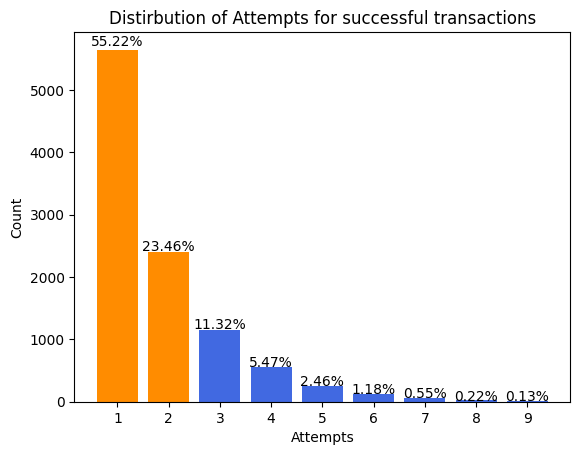

In [20]:

def plot_distribution_main(df,col,title,xlabel,ylabel,color_filter=False):
    class_count = {str(key):val for key,val in dict(df[col].value_counts()).items()}
    class_per = {i:round(((val/len(df[col]))*100),2) for i,val in enumerate(class_count.values())}
    if color_filter:
        color_lst = ['DarkOrange' if i>20 else 'RoyalBlue' for i in class_per.values()]
        graph = plt.bar(class_count.keys(),class_count.values(),color=color_lst)
    else:
        graph = plt.bar(class_count.keys(),class_count.values())
    i=0
    for g in graph:
        wid = g.get_width()
        hei = g.get_height()
        x,y = g.get_xy()
        plt.text(x+wid/2,y+hei*1.01,
                 f'{class_per[i]}%',
                ha='center')
        
        i+=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
success_aggregated_count = all_success_df.groupby(by=['transactionID','amount']).count().reset_index()
plot_distribution_main(success_aggregated_count,'tmsp','Distirbution of Attempts for successful transactions','Attempts','Count',True)
plt.savefig('Attempts.png',dpi=200)

In [21]:
filtered_IDS = success_aggregated_count[success_aggregated_count['tmsp']<=2]['transactionID'].tolist()
filtered_df = all_success_df[all_success_df['transactionID'].isin(filtered_IDS)]

print('Number of unique transactions after filtering transactions with more than 2 attempts: ',len(filtered_df['transactionID'].unique()))


Number of unique transactions after filtering transactions with more than 2 attempts:  8047


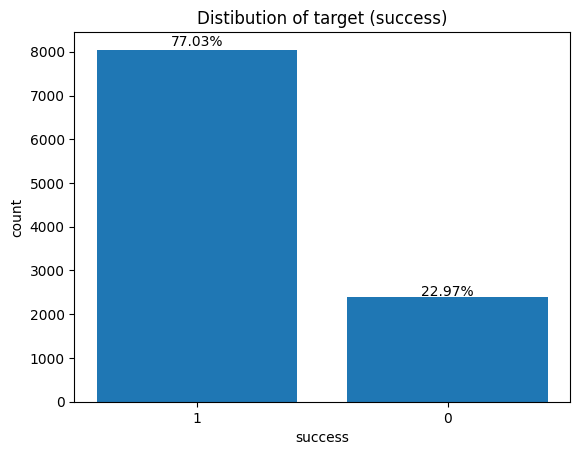

In [22]:
plot_distribution_main(filtered_df,'success','Distibution of target (success)','success','count')
plt.savefig('Class distibution.png',dpi=200)

In [23]:
def customMinMaxScaler(train,val,test,col):
    minval = train[col].min()
    maxval = train[col].max()
    train[col] = (train[col]-minval)/(maxval-minval)
    val[col] = (val[col]-minval)/(maxval-minval)
    test[col] = (test[col]-minval)/(maxval-minval)
    return {'minval':minval,'maxval':maxval}
    


def preprocess_df(df,shape=False,undersample=False,oversample=False):
    from sklearn.model_selection import train_test_split

    df = df.drop(['tmsp','date','transactionID'],axis=1)
    df = pd.get_dummies(df,columns=['card','country','PSP'])
    
    
    X,Y = df.drop('success',axis=1),df[['success']]

    if undersample:
        print('Before undersampling: ',dict(Y['success'].value_counts()))
        undersampler = RandomUnderSampler(sampling_strategy='majority')
        X, Y = undersampler.fit_resample(X, Y)
        print('After undersampling: ',dict(Y['success'].value_counts()))
    
    
    trainX,valX,trainY,valY = train_test_split(X,Y,test_size=0.3,random_state=0)
    valX,testX,valY,testY = train_test_split(valX,valY,test_size=0.35,random_state=0)
    
    if shape:
        print(trainX.shape,trainY.shape)
        print(valX.shape,valY.shape)
        print(testX.shape,testY.shape)
        
        
        print(f'Train data percentage: {round(((len(trainX)/len(X))*100),2)}%')
        print(f'Validation data percentage: {round(((len(valX)/len(X))*100),2)}%')
        print(f'Test data percentage: {round(((len(testX)/len(X))*100),2)}%')
        
    if oversample:
        print('Before oversampling: ',dict(trainY['success'].value_counts()))
        oversampler = RandomOverSampler(sampling_strategy='minority')
        trainX, trainY = oversampler.fit_resample(trainX, trainY)
        print('After oversampling: ',dict(trainY['success'].value_counts()))
        
    sampled_df = pd.concat([trainX,trainY],axis=1)
    scaler_dict = {}
    scaler_dict['amount'] = customMinMaxScaler(trainX,valX,testX,'amount')
    scaler_dict['min'] = customMinMaxScaler(trainX,valX,testX,'min')
    scaler_dict['second'] = customMinMaxScaler(trainX,valX,testX,'second')
    scaler_dict['day'] = customMinMaxScaler(trainX,valX,testX,'day')
    scaler_dict['hour'] = customMinMaxScaler(trainX,valX,testX,'hour')
    
    
    
    return sampled_df,trainX,valX,testX,trainY,valY,testY,scaler_dict

sampled_df,trainX,valX,testX,trainY,valY,testY,scaler_dict = preprocess_df(filtered_df,shape=True,undersample=False,oversample=True)
    

(7312, 17) (7312, 1)
(2037, 17) (2037, 1)
(1097, 17) (1097, 1)
Train data percentage: 70.0%
Validation data percentage: 19.5%
Test data percentage: 10.5%
Before oversampling:  {1: 5598, 0: 1714}
After oversampling:  {1: 5598, 0: 5598}


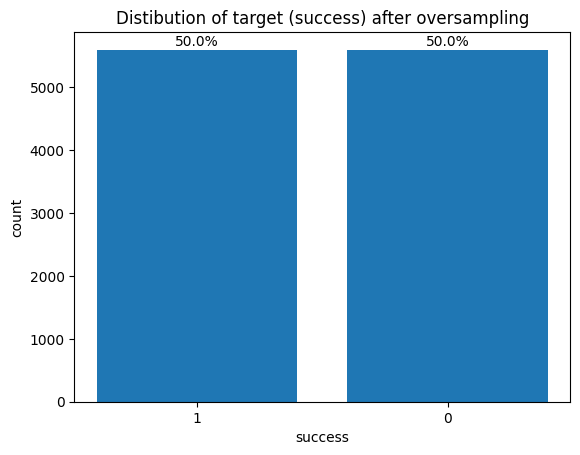

In [24]:
plot_distribution_main(sampled_df,'success','Distibution of target (success) after oversampling','success','count')
plt.savefig('Class distibution.png',dpi=200)

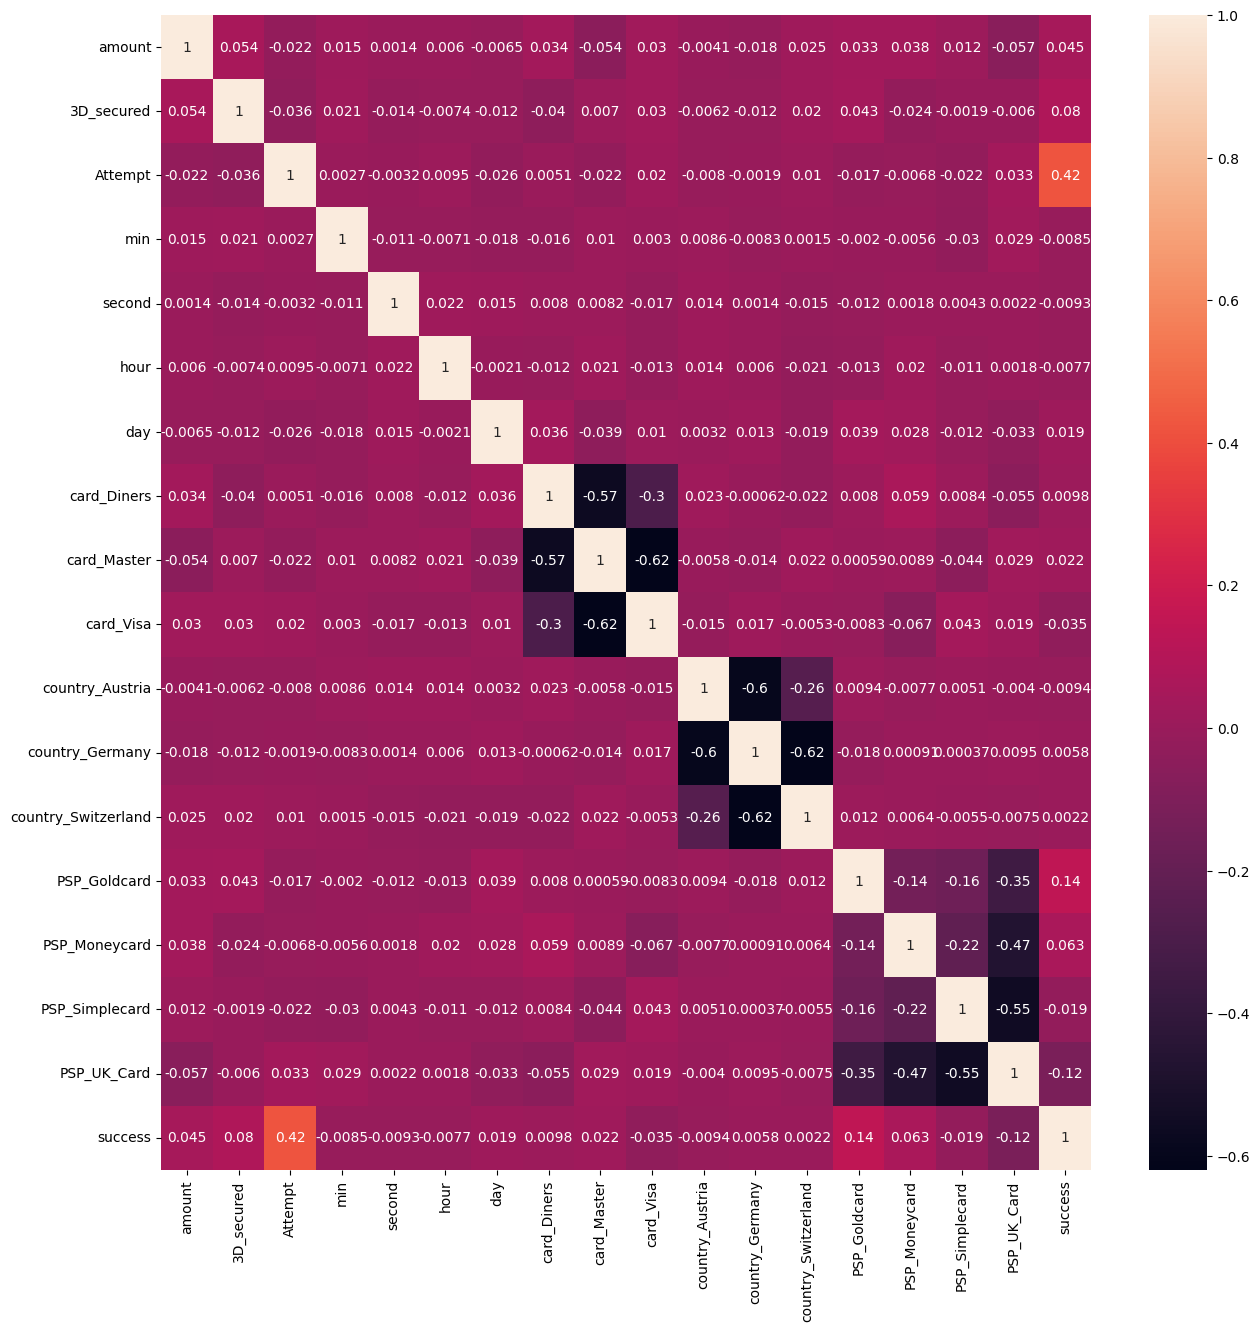

In [25]:
cm = pd.concat([trainX,trainY],axis=1)
plt.figure(figsize=(15,15))
sns.heatmap(cm.corr(),annot=True)
plt.show()

## Model Training

In [26]:
def negative_rates(true,pred):
    CM = confusion_matrix(true, pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP) 
    
    TPR = round(TPR,3)
    TNR = round(TNR,3)
    
    return {'TPR':TPR,'TNR':TNR}

#### GaussianNB, Multinomial and Logistic Regression models

In [27]:

Gaus_NB = GaussianNB()
Gaus_NB.fit(trainX,trainY)
train_pred = Gaus_NB.predict(trainX)
val_pred = Gaus_NB.predict(valX)
metric_dict = {}
metric_dict['Gausian NB'] = {
    'Train_acc':Gaus_NB.score(trainX,trainY),
    'Val_acc':Gaus_NB.score(valX,valY),
    'Train TPR':negative_rates(trainY,train_pred)['TPR'],
    'Train TNR':negative_rates(trainY,train_pred)['TNR'],
    'Val TPR':negative_rates(valY,val_pred)['TPR'],
    'Val TNR':negative_rates(valY,val_pred)['TNR'],

}

Multi_NB = MultinomialNB()
Multi_NB.fit(trainX,trainY)
train_pred = Multi_NB.predict(trainX)
val_pred = Multi_NB.predict(valX)
metric_dict['Multi NB'] = {
    'Train_acc':Multi_NB.score(trainX,trainY),
    'Val_acc':Multi_NB.score(valX,valY),
    'Train TPR':negative_rates(trainY,train_pred)['TPR'],
    'Train TNR':negative_rates(trainY,train_pred)['TNR'],
    'Val TPR':negative_rates(valY,val_pred)['TPR'],
    'Val TNR':negative_rates(valY,val_pred)['TNR'],

}


log_reg = LogisticRegression()
log_reg.fit(trainX,trainY)
train_pred = log_reg.predict(trainX)
val_pred = log_reg.predict(valX)

metric_dict['Logistic Reg'] = {
    'Train_acc':log_reg.score(trainX,trainY),
    'Val_acc':log_reg.score(valX,valY),
    'Train TPR':negative_rates(trainY,train_pred)['TPR'],
    'Train TNR':negative_rates(trainY,train_pred)['TNR'],
    'Val TPR':negative_rates(valY,val_pred)['TPR'],
    'Val TNR':negative_rates(valY,val_pred)['TNR'],

}

display(pd.DataFrame(metric_dict).transpose())
print('Confusion Matrix of GaussianNB is \n',confusion_matrix(valY,Gaus_NB.predict(valX)))
print('Confusion Matrix of GaussianNB is \n',confusion_matrix(valY,Multi_NB.predict(valX)))
print('Confusion Matrix of Logistic_Reg is \n',confusion_matrix(valY,log_reg.predict(valX)))

,Train_acc,Val_acc,Train TPR,Train TNR,Val TPR,Val TNR
Gausian NB,0.650143,0.447226,0.300,1.000,0.295,1.000
Multi NB,0.607985,0.495827,0.439,0.777,0.426,0.752
Logistic Reg,0.689085,0.566519,0.501,0.877,0.481,0.877


Confusion Matrix of GaussianNB is 
 [[ 439    0]
 [1126  472]]
Confusion Matrix of GaussianNB is 
 [[330 109]
 [918 680]]
Confusion Matrix of Logistic_Reg is 
 [[385  54]
 [829 769]]


#### Training and validating KNN 

In [28]:

metric_KNN_dict = {}
for neigh in [3,5,7,11,13]:
    KNN_model = KNeighborsClassifier(n_neighbors=neigh)
    KNN_model.fit(trainX,trainY)
    train_predictions = KNN_model.predict(trainX)
    test_predictions = KNN_model.predict(valX)
    metric_KNN_dict[neigh] =  {'Train_accuracy':round(accuracy_score(trainY,train_predictions),3),
    'Val_accuracy':round(accuracy_score(valY,test_predictions),3),
   'Train_TNR': negative_rates(trainY,train_predictions)['TNR'],
    'Train_TPR': negative_rates(trainY,train_predictions)['TPR'],
    'Val_TNR': negative_rates(valY,test_predictions)['TNR'],
    'Val_TPR': negative_rates(valY,test_predictions)['TPR'],
    'Train_f1score':round(f1_score(trainY,train_predictions,average='micro'),3),
    'Val_f1score':round(f1_score(valY,test_predictions,average='micro'),3)}

display(pd.DataFrame(metric_KNN_dict).transpose())

,Train_accuracy,Val_accuracy,Train_TNR,Train_TPR,Val_TNR,Val_TPR,Train_f1score,Val_f1score
3,0.902,0.667,0.988,0.817,0.526,0.706,0.902,0.667
5,0.843,0.653,0.952,0.734,0.622,0.662,0.843,0.653
7,0.807,0.645,0.909,0.706,0.638,0.646,0.807,0.645
11,0.774,0.647,0.878,0.670,0.708,0.630,0.774,0.647
13,0.762,0.640,0.863,0.662,0.731,0.615,0.762,0.640


In [29]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(trainX,trainY)
train_predictions = KNN_model.predict(trainX)
val_predictions = KNN_model.predict(valX)
print(confusion_matrix(valY,val_predictions))

[[ 273  166]
 [ 540 1058]]


####  Training and validating SVC

In [30]:
metric_SVM_dict = [] 
from sklearn.svm import SVC
for kernel in ['linear','rbf','poly']:
    for c in [0.1,1,10]:
        svm = SVC(kernel=kernel,C=c)
        svm.fit(trainX,trainY)
        train_predictions = svm.predict(trainX)
        val_predictions = svm.predict(valX)
        metric_SVM_dict.append({'kernel':kernel,'c':c,'Train_accuracy':round(accuracy_score(trainY,train_predictions),3),
    'Val_accuracy':round(accuracy_score(valY,val_predictions),3),
   'Train_TNR': negative_rates(trainY,train_predictions)['TNR'],
    'Train_TPR': negative_rates(trainY,train_predictions)['TPR'],
    'Val_TNR': negative_rates(valY,val_predictions)['TNR'],
    'Val_TPR': negative_rates(valY,val_predictions)['TPR'],
    'Train_f1score':round(f1_score(trainY,train_predictions,average='micro'),3),
    'Val_f1score':round(f1_score(valY,val_predictions,average='micro'),3)})

display(pd.DataFrame(metric_SVM_dict))

,kernel,c,Train_accuracy,Val_accuracy,Train_TNR,Train_TPR,Val_TNR,Val_TPR,Train_f1score,Val_f1score
0,linear,0.1,0.683,0.515,0.954,0.412,0.929,0.402,0.683,0.515
1,linear,1.0,0.683,0.515,0.954,0.412,0.929,0.402,0.683,0.515
2,linear,10.0,0.683,0.515,0.954,0.412,0.929,0.402,0.683,0.515
3,rbf,0.1,0.705,0.592,0.866,0.545,0.818,0.529,0.705,0.592
4,rbf,1.0,0.725,0.626,0.847,0.602,0.800,0.578,0.725,0.626
5,rbf,10.0,0.756,0.611,0.901,0.611,0.795,0.560,0.756,0.611
6,poly,0.1,0.706,0.610,0.837,0.575,0.800,0.558,0.706,0.610
7,poly,1.0,0.726,0.620,0.855,0.598,0.802,0.569,0.726,0.620
8,poly,10.0,0.741,0.620,0.876,0.606,0.797,0.571,0.741,0.620


In [31]:
svm_model = SVC(kernel='poly',C=10)
svm_model.fit(trainX,trainY)
train_predictions = svm_model.predict(trainX)
val_predictions = svm_model.predict(valX)
print(confusion_matrix(valY,val_predictions))

[[350  89]
 [685 913]]


### Bagging methods - RandomForestClassifier

In [32]:
Random_forest_lst = []
for j in [50,100,200,500,1000]:
    for i in [5,10,100]:
        Forest = RandomForestClassifier(max_depth=i,n_estimators=j,random_state=13)
        Forest.fit(trainX,trainY)
        train_predictions = Forest.predict(trainX)
        test_predictions = Forest.predict(valX)
        
        Random_forest_lst.append(        
        {'n_estimators':j,'Max_depth':i,
         'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
    'Validation_accuracy':round(accuracy_score(valY,test_predictions),3),
   'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
    'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
        'Validation TNR': negative_rates(valY,test_predictions)['TNR'],
    'Validation TPR': negative_rates(valY,test_predictions)['TPR']})
 
display(pd.DataFrame(Random_forest_lst))

,n_estimators,Max_depth,Training_accuracy,Validation_accuracy,Training TNR,Training TPR,Validation TNR,Validation TPR
0,50,5,0.702,0.551,0.936,0.467,0.902,0.454
1,50,10,0.829,0.642,0.979,0.680,0.781,0.603
2,50,100,1.000,0.735,1.000,1.000,0.342,0.844
3,100,5,0.710,0.564,0.929,0.491,0.886,0.475
4,100,10,0.831,0.641,0.978,0.683,0.763,0.607
5,100,100,1.000,0.735,1.000,1.000,0.323,0.848
6,200,5,0.711,0.568,0.925,0.497,0.884,0.481
7,200,10,0.832,0.646,0.980,0.685,0.765,0.613
8,200,100,1.000,0.743,1.000,1.000,0.323,0.859
9,500,5,0.712,0.572,0.919,0.506,0.872,0.489


In [33]:
Forest = RandomForestClassifier(max_depth=10,n_estimators=500)
Forest.fit(trainX,trainY)
train_predictions = Forest.predict(trainX)
test_predictions = Forest.predict(valX)
print(confusion_matrix(valY,test_predictions))

[[329 110]
 [623 975]]


### Bagging methods - ExtraTreeClassifier

In [34]:

ExtraTrees_lst = []
# for estim in [DecisionTreeClassifier(),SVC(probability=True),GaussianNB()]:
for depth in [5,10,100]:
    for n_estim in [5,10,100,200]:
        ExtraTree = ExtraTreesClassifier(n_estimators=n_estim,max_depth=depth
                                     )
        ExtraTree.fit(trainX, trainY)
        train_predictions = ExtraTree.predict(trainX)
        val_predictions = ExtraTree.predict(valX)
        ExtraTrees_lst.append(        
            {'n_estimators':n_estim,'max_depth':depth,
             'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
        'Validation_accuracy':round(accuracy_score(valY,val_predictions),3),
       'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
        'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
            'Validation TNR': negative_rates(valY,val_predictions)['TNR'],
        'Validation TPR': negative_rates(valY,val_predictions)['TPR']})



In [35]:
ExtraTrees_df = pd.DataFrame(ExtraTrees_lst)
ExtraTrees_df

ExtraTree = ExtraTreesClassifier(n_estimators=10,max_depth=10
                             )
ExtraTree.fit(trainX, trainY)
train_predictions = ExtraTree.predict(trainX)
val_predictions = ExtraTree.predict(valX)
cf =  confusion_matrix(valY,val_predictions)
cf

array([[347,  92],
       [662, 936]], dtype=int64)

### Bagging methods - StackingClassifier

In [36]:


estimators = [
     ('rf', DecisionTreeClassifier(random_state=42)),
     ('svc',LinearSVC(random_state=42))
]
stack = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)

stack.fit(trainX,trainY)

train_predictions = stack.predict(trainX)
val_predictions = stack.predict(valX)

display(pd.DataFrame([{
'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
'Validation_accuracy':round(accuracy_score(valY,val_predictions),3),
'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
'Validation TNR': negative_rates(valY,val_predictions)['TNR'],
'Validation TPR': negative_rates(valY,val_predictions)['TPR']}]))

,Training_accuracy,Validation_accuracy,Training TNR,Training TPR,Validation TNR,Validation TPR
0,1.0,0.718,1.0,1.0,0.346,0.82


In [37]:

estimators = [
     ('Dt', DecisionTreeClassifier(random_state=42)),
     ('svc',SVC(random_state=42)),
    ('rf',RandomForestClassifier(n_estimators=10,random_state=42)),
]
stack = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)

stack.fit(trainX,trainY)

train_predictions = stack.predict(trainX)
val_predictions = stack.predict(valX)

display(pd.DataFrame([{
'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
'Validation_accuracy':round(accuracy_score(valY,val_predictions),3),
'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
'Validation TNR': negative_rates(valY,val_predictions)['TNR'],
'Validation TPR': negative_rates(valY,val_predictions)['TPR']}]))


cf  = confusion_matrix(valY,val_predictions)
cf

,Training_accuracy,Validation_accuracy,Training TNR,Training TPR,Validation TNR,Validation TPR
0,0.999,0.765,0.998,1.0,0.159,0.932


array([[  70,  369],
       [ 109, 1489]], dtype=int64)

### Boosting methods - AdaBoost classifier

In [ ]:

AdaBoost_lst = []
for estim in [LogisticRegression(),DecisionTreeClassifier(),SVC(probability=True)]:
    for n_estim in [10,100]:
        AdaBoost = AdaBoostClassifier(n_estimators=n_estim,
                                         base_estimator=estim
                                     )
        AdaBoost.fit(trainX, trainY)
        train_predictions = AdaBoost.predict(trainX)
        val_predictions = AdaBoost.predict(valX)
        AdaBoost_lst.append(        
            {
                'n_estimators':n_estim,
                'estim':estim,
             'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
        'Validation_accuracy':round(accuracy_score(valY,val_predictions),3),
       'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
        'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
            'Validation TNR': negative_rates(valY,val_predictions)['TNR'],
        'Validation TPR': negative_rates(valY,val_predictions)['TPR']})

AdaBoost_df = pd.DataFrame(AdaBoost_lst)
AdaBoost_df

In [ ]:
 AdaBoost = AdaBoostClassifier(n_estimators=10,
                                         base_estimator=SVC(probability=True)
                                     )
AdaBoost.fit(trainX, trainY)
train_predictions = AdaBoost.predict(trainX)
val_predictions = AdaBoost.predict(valX)
cf = confusion_matrix(valY,val_predictions)
cf


### Boosting methods - GradBoost classifier

In [ ]:

GradBoost_lst = []
# for estim in [DecisionTreeClassifier(),SVC(probability=True),GaussianNB()]:
for loss in ['log_loss','exponential']:
    for n_estim in [5,10,100,200]:
        GradBoost = GradientBoostingClassifier(n_estimators=n_estim,loss=loss
                                     )
        GradBoost.fit(trainX, trainY)
        train_predictions = GradBoost.predict(trainX)
        val_predictions = GradBoost.predict(valX)
        GradBoost_lst.append(        
            {'n_estimators':n_estim,'loss':loss,
             'Training_accuracy':round(accuracy_score(trainY,train_predictions),3),
        'Validation_accuracy':round(accuracy_score(valY,val_predictions),3),
       'Training TNR': negative_rates(trainY,train_predictions)['TNR'],
        'Training TPR': negative_rates(trainY,train_predictions)['TPR'],
            'Validation TNR': negative_rates(valY,val_predictions)['TNR'],
        'Validation TPR': negative_rates(valY,val_predictions)['TPR']})

GradBoost_df = pd.DataFrame(GradBoost_lst)
GradBoost_df

In [ ]:
GradBoost = GradientBoostingClassifier(n_estimators=100,loss='exponential')
GradBoost.fit(trainX, trainY)
train_predictions = GradBoost.predict(trainX)
val_predictions = GradBoost.predict(valX)
cf = confusion_matrix(valY,val_predictions)
cf


### Training the Neural Network

In [26]:
import tensorflow.keras.backend as K
def custom_weighted_binary_crossentropy(zero_weight=0.5, one_weight=0.5):

    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = K.cast(y_true, dtype=tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy from probabilities.
        bce = y_true * tf.math.log(y_pred + epsilon)
        bce += (1 - y_true) * tf.math.log(1 - y_pred + epsilon)
        bce = -bce

        # Apply the weights to each class individually
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        # Return the mean error
        return tf.reduce_mean(weighted_bce)

    return weighted_binary_crossentropy


def cal_TPR(y_true, y_pred):
    y_pred = np.where(y_pred>=0.5,1,0)
    TP = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 1)
    FN = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 0)
    TP = K.sum(K.variable(TP))
    FN = K.sum(K.variable(FN))
    TPR = TP/(TP+FN)
    return TPR

def cal_TNR(y_true, y_pred):
    y_pred = np.where(y_pred>=0.5,1,0)
    TN = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 0)
    FP = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 1)
    TN = K.sum(K.variable(TN))
    FP = K.sum(K.variable(FP))
    TNR = TN/(TN+FP)
    return TNR


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
# Custom callback for saving the metrics and model object in a pandas dataframe
class CustomCallback(keras.callbacks.Callback):
    def __init__(self):
        self.callback_lst = []
        self.callback_df = []
        
    def on_train_begin(self, logs=None):
        self.callback_lst = []

    def on_train_end(self, logs=None):
        self.callback_df = pd.DataFrame(self.callback_lst)

    def on_epoch_end(self, epoch, logs=None):
        tmp_dict = {key:val for key,val in logs.items()}
        tmp_dict['model'] = self.model
        self.callback_lst.append(tmp_dict)
        
        


#### Training the model with oversampled data

In [28]:
input_layer = tf.keras.Input(shape=(17))
x = tf.keras.layers.Dense(100,activation='relu')(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(50,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(10,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)


model = tf.keras.models.Model(inputs=input_layer,outputs=output)
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 100)               1800      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11    

In [29]:
model.compile(
    loss = custom_weighted_binary_crossentropy(zero_weight=0.4, one_weight=0.6),
    metrics=['accuracy',f1_m,cal_TNR,cal_TPR],optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),run_eagerly=True)

In [30]:
callback_obj  = CustomCallback()
history = model.fit(trainX,trainY,validation_data=(valX,valY),epochs=20
                   ,callbacks=[callback_obj])

Epoch 1/20
350/350 [==============================] - 30s 83ms/step - loss: 0.3091 - accuracy: 0.5676 - f1_m: 0.6502 - cal_TNR: 0.3061 - cal_TPR: 0.8318 - val_loss: 0.2832 - val_accuracy: 0.6436 - val_f1_m: 0.7330 - val_cal_TNR: 0.6474 - val_cal_TPR: 0.6402
Epoch 2/20
350/350 [==============================] - 29s 83ms/step - loss: 0.2809 - accuracy: 0.6574 - f1_m: 0.6505 - cal_TNR: 0.6577 - cal_TPR: 0.6579 - val_loss: 0.2808 - val_accuracy: 0.6352 - val_f1_m: 0.7179 - val_cal_TNR: 0.7351 - val_cal_TPR: 0.6084
Epoch 3/20
350/350 [==============================] - 29s 83ms/step - loss: 0.2748 - accuracy: 0.6784 - f1_m: 0.6574 - cal_TNR: 0.7131 - cal_TPR: 0.6432 - val_loss: 0.2846 - val_accuracy: 0.6166 - val_f1_m: 0.6929 - val_cal_TNR: 0.7915 - val_cal_TPR: 0.5685
Epoch 4/20
350/350 [==============================] - 28s 81ms/step - loss: 0.2726 - accuracy: 0.6843 - f1_m: 0.6585 - cal_TNR: 0.7393 - cal_TPR: 0.6292 - val_loss: 0.2807 - val_accuracy: 0.6230 - val_f1_m: 0.7021 - val_cal_TN

In [31]:
NN_model = callback_obj.callback_df.iloc[10]['model']

In [34]:
valpred = NN_model.predict(valX)
valpred = np.where(valpred>=0.5,1,0)
print('Validation Confusion Matrix: \n',confusion_matrix(valY,valpred))
print('Validation accuracy: ',accuracy_score(valY,valpred))
testpred = NN_model.predict(testX)
testpred = np.where(testpred>=0.5,1,0)
print('Test Confusion Matrix: \n',confusion_matrix(testY,testpred))
print('Test accuracy: ',accuracy_score(testY,testpred))

64/64 [==============================] - 0s 7ms/step
Validation Confusion Matrix: 
 [[334 105]
 [607 991]]
Validation accuracy:  0.6504663721158567
35/35 [==============================] - 0s 7ms/step
Test Confusion Matrix: 
 [[187  59]
 [313 538]]
Test accuracy:  0.6608933454876937


In [35]:
class ValueError(Exception):
    def __init__(self):
        self.message = "Passed data is not a DataFrame"
        super().__init__(self.message)

class ColumnNotAvailable(Exception):
    def __init__(self):
        self.message='Required column is not available'
        super().__init__(self.message)

In [36]:
def scale_features(scaler_dict,df):
    for key,val in scaler_dict.items():
        df[key] = (df[key] - val['minval'])/(val['maxval']-val['minval'])

In [40]:
def make_prediction(df,model,scaler_dict,do_scale):
    predef_col = ['amount', '3D_secured', 'Attempt', 'min', 'second', 'hour', 'day',
       'card_Diners', 'card_Master', 'card_Visa', 'country_Austria',
       'country_Germany', 'country_Switzerland']
    
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError()  
    
    res = set(df.columns).issubset(predef_col)
    
    if not res:
        raise ColumnNotAvailable()
    else:
        df = df[predef_col]
        
        if do_scale:
            scale_features(scaler_dict,df)
            
        GoldCard_tmp  =   pd.DataFrame([{'PSP_Goldcard':1,'PSP_Moneycard':0,'PSP_Simplecard':0,'PSP_UK_Card':0}])
        GoldCard_df = df.copy(deep=True)
        GoldCard_df['PSP_Goldcard'] = 1
        GoldCard_df['PSP_Moneycard'] = 0
        GoldCard_df['PSP_Simplecard'] = 0
        GoldCard_df['PSP_UK_Card'] = 0
        GoldCard_df['Attempt'] = 1
        
        MoneyCard_df = df.copy(deep=True)
        MoneyCard_df['PSP_Goldcard'] = 0
        MoneyCard_df['PSP_Moneycard'] = 1
        MoneyCard_df['PSP_Simplecard'] = 0
        MoneyCard_df['PSP_UK_Card'] = 0
        MoneyCard_df['Attempt'] = 1
        
        Simplecard_df = df.copy(deep=True)
        Simplecard_df['PSP_Goldcard'] = 0
        Simplecard_df['PSP_Moneycard'] = 0
        Simplecard_df['PSP_Simplecard'] = 1
        Simplecard_df['PSP_UK_Card'] = 0
        Simplecard_df['Attempt'] = 1
        
        UKCard_df = df.copy(deep=True)
        UKCard_df['PSP_Goldcard'] = 0
        UKCard_df['PSP_Moneycard'] = 0
        UKCard_df['PSP_Simplecard'] = 0
        UKCard_df['PSP_UK_Card'] = 1
        UKCard_df['Attempt'] = 1
        
        Gold_pred =  np.squeeze(model.predict(GoldCard_df))
        Money_pred = np.squeeze(model.predict(MoneyCard_df))
        Simple_pred = np.squeeze(model.predict(Simplecard_df))
        UKCard_pred = np.squeeze(model.predict(UKCard_df))
        prediction_df = pd.DataFrame({'PSP_Goldcard':Gold_pred,
                                     'PSP_Moneycard':Money_pred,
                                     'PSP_Simplecard':Simple_pred,
                                     'PSP_UK_Card':UKCard_pred})
        
    return prediction_df

In [42]:
testdf = pd.concat([testX,testY],axis=1)

first_attempt_success_test = testdf[(testdf['success']==1)&(testdf['Attempt']==1)]
test_X = first_attempt_success_test.drop(['PSP_Goldcard','PSP_Moneycard','PSP_Simplecard',
                                          'PSP_UK_Card','success'],axis=1)
test_Y = first_attempt_success_test[['PSP_Goldcard','PSP_Moneycard','PSP_Simplecard',
                                          'PSP_UK_Card']]
test_Y = test_Y.idxmax(axis=1)

prediction_df =  make_prediction(test_X,NN_model,scaler_dict,do_scale=False)

19/19 [==============================] - 0s 6ms/step


In [43]:
test_pred = prediction_df.idxmax(axis=1)
confusion_matrix(test_Y,test_pred)

array([[105,  11,   0,   1],
       [ 76,  21,   3,   1],
       [ 80,  26,   6,   1],
       [204,  35,  18,  17]], dtype=int64)

### Training a neural network model without oversampling

In [45]:
sampled_df,trainX_raw,valX_raw,testX_raw,trainY_raw,valY_raw,testY_raw,scaler_dict_raw = preprocess_df(filtered_df,shape=True,undersample=False,oversample=False)

(7312, 17) (7312, 1)
(2037, 17) (2037, 1)
(1097, 17) (1097, 1)
Train data percentage: 70.0%
Validation data percentage: 19.5%
Test data percentage: 10.5%


In [61]:
input_layer = tf.keras.Input(shape=(17))


x = tf.keras.layers.Dense(300,activation='relu')(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(100,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(50,activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)


raw_model = tf.keras.models.Model(inputs=input_layer,outputs=output)
raw_model.summary()




Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_24 (Dense)            (None, 300)               5400      
                                                                 
 dropout_10 (Dropout)        (None, 300)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               30100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 50)                5050      
                                                                 
 dense_27 (Dense)            (None, 20)                1020

In [62]:
raw_model.compile(
    loss = custom_weighted_binary_crossentropy(zero_weight=0.7, one_weight=0.3),
    metrics=['acc',f1_m,cal_TNR,cal_TPR],optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),run_eagerly=True)

In [63]:
raw_callback_obj  = CustomCallback()
raw_history = raw_model.fit(trainX_raw,trainY_raw,validation_data=(valX_raw,valY_raw),epochs=30
                   ,callbacks=[raw_callback_obj],batch_size=50)

Epoch 1/30
147/147 [==============================] - 14s 98ms/step - loss: 0.2455 - acc: 0.7165 - f1_m: 0.8126 - cal_TNR: 0.2995 - cal_TPR: 0.8456 - val_loss: 0.2212 - val_acc: 0.6696 - val_f1_m: 0.7620 - val_cal_TNR: 0.6134 - val_cal_TPR: 0.6856
Epoch 2/30
147/147 [==============================] - 14s 96ms/step - loss: 0.2241 - acc: 0.6451 - f1_m: 0.7253 - cal_TNR: 0.7090 - cal_TPR: 0.6266 - val_loss: 0.2200 - val_acc: 0.6441 - val_f1_m: 0.7364 - val_cal_TNR: 0.6437 - val_cal_TPR: 0.6458
Epoch 3/30
147/147 [==============================] - 14s 97ms/step - loss: 0.2206 - acc: 0.6365 - f1_m: 0.7104 - cal_TNR: 0.7615 - cal_TPR: 0.5999 - val_loss: 0.2221 - val_acc: 0.5272 - val_f1_m: 0.5736 - val_cal_TNR: 0.9336 - val_cal_TPR: 0.4157
Epoch 4/30
147/147 [==============================] - 14s 97ms/step - loss: 0.2188 - acc: 0.6439 - f1_m: 0.7203 - cal_TNR: 0.7447 - cal_TPR: 0.6139 - val_loss: 0.2152 - val_acc: 0.5935 - val_f1_m: 0.6679 - val_cal_TNR: 0.8304 - val_cal_TPR: 0.5300
Epoch 5/

In [69]:
NN_model_raw = raw_callback_obj.callback_df.iloc[23]['model']

In [70]:
testdf_raw = pd.concat([testX_raw,testY_raw],axis=1)

first_attempt_success_test_raw = testdf_raw[(testdf_raw['success']==1)&(testdf_raw['Attempt']==1)]
test_X_raw = first_attempt_success_test_raw.drop(['PSP_Goldcard','PSP_Moneycard','PSP_Simplecard',
                                          'PSP_UK_Card','success'],axis=1)
test_Y_raw = first_attempt_success_test_raw[['PSP_Goldcard','PSP_Moneycard','PSP_Simplecard',
                                          'PSP_UK_Card']]
test_Y_raw = test_Y_raw.idxmax(axis=1)

prediction_df_raw =  make_prediction(test_X_raw,NN_model_raw,scaler_dict_raw,do_scale=False)

19/19 [==============================] - 0s 5ms/step


In [71]:
test_pred_raw = prediction_df_raw.idxmax(axis=1)
confusion_matrix(test_Y_raw,test_pred_raw)

array([[114,   3,   0,   0],
       [ 94,   6,   0,   1],
       [102,  11,   0,   0],
       [251,  18,   2,   3]], dtype=int64)